<a href="https://colab.research.google.com/github/fachra/FourierPotential/blob/main/FPM_demo_cupy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theory
The complex transverse water proton magnetization $M$
in the rotating frame satisfies the Bloch-Torrey PDE:
\begin{alignat}{4}
	  & \frac{\partial}{\partial t}{M(x,t)} &                       & = -\jmath\gamma f(t) \mathbf{g} \cdot x \,M(x,t)
	+ \nabla \cdot (\mathcal{D}_0 \nabla M(x,t)), &                                       & \quad x \in \Omega,
\end{alignat}
where $\gamma=267.513\, rad\,\mu s^{-1}T^{-1}$ is the
gyromagnetic ratio of the water proton, $\jmath$ is the imaginary unit,
$\mathcal{D}_0$ is the intrinsic diffusion coefficient in the neuron compartment $\Omega$.

We make the following assumptions:
- negligible membrane permeability
- PGSE sequence with $\delta \ll \Delta$
- Diffusion in a closed 2D region $\Omega$

We transform the Bloch-Torrey equation to a diffusion equation subjecting to zero initial conditions and non-zero Neumann boundary conditions.
Define
$$
\omega(x,t) \equiv M(x,t+\delta)
-\rho e^{-4\pi^2 \mathcal{D}_0 \|q\|^2 t} e^{-2\pi\jmath q \cdot x},  \quad x \in \Omega,
\quad t \in [0,\Delta-\delta]$$
where $q =\delta\gamma \mathbf{g}/2 \pi$
so that $\omega(x,t)$ satisfies the diffusion equation:
$$
\frac{\partial}{\partial t}{\omega(x,t)}
= \nabla \cdot (\mathcal{D}_0 \nabla \omega(x,t)), \quad x \in \Omega,
\quad t \in [0,\Delta-\delta],
$$
$$ \mathcal{D}_0 \nabla \omega(x,t) \cdot \mathbf{n}
	= \jmath\mathcal{D}_0\rho \mathbf{q} \cdot \mathbf{n}
	e^{--4\pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2 t}e^{-2\pi \jmath \mathbf{q}\cdot x},
	\quad x \in \partial \Omega , \quad t \in [0,\Delta-\delta],
$$
$$
	\omega(x,0) = 0, \quad x \in \Omega.
$$

The diffusion MRI signal $\mathcal{S}$ can be formulated in terms of $\omega$:
$$
\mathcal{S} = |\Omega|\rho e^{-4\pi^2 \mathcal{D}_0  \|\mathbf{q}\|^2 (\Delta - \delta)} + \overline{\omega}(\mathbf{q}, \Delta-\delta),
$$
with
$$
\overline{\omega}(\mathbf{q}, t) = \mathcal{D}_0 \int_{0}^{t} \int_{\partial \Omega} -2\pi \jmath \mathbf{q} \cdot \mathbf{n}
e^{-4\pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2 (t-\tau)} \omega(\mathbf{x}, \tau) e^{2\pi \jmath \mathbf{q} \cdot \mathbf{x}} ds_{\mathbf{x}} d\tau
$$
and
$$\rho = 1 A/m.$$

In [ ]:
!pip install cupy-cuda101
!pip install scipy
!wget https://github.com/fachra/FourierPotential/raw/main/geo.mat
import warnings
import scipy.io as io
import matplotlib.pyplot as plt
import time
try:
    import cupy as xp
    import numpy as np
    xp.empty(1)
except:
    import numpy as np
    xp = np
    warnings.warn("GPU/cupy is not detected, Numpy is used. Modify Edit -> Notebook settings -> Hardware accelerator -> GPU to use cupy.")

ctype = xp.complex64  # complex float number
rtype = xp.float64

In [2]:
def get_q(sdelta, bdelta, b):
    # generate 3 q-vectors 
    # (just an examplary function to give some q-vectors )
    abs_q = np.sqrt(b/(bdelta-sdelta/3))/(2*np.pi)
    qx = xp.linspace(0, abs_q, 10).reshape((1, -1))
    qy = xp.zeros(10).reshape((1, -1))
    q = xp.concatenate((qx, qy), axis=0)  # [2 x n_q] (1/um)
    q_square = (q**2).sum(axis=0).reshape((1, -1))  # [1 x n_q]
    return q, q_square, abs_q

# dMRI settings
D0 = 1e-3  # (um^2/us)
sdelta, bdelta = 2500, 5000  # (us)
b = 3000  # (us/um^2)
q, q_square, q_max = get_q(sdelta, bdelta, b)
print(q)

[[0.         0.01500527 0.03001054 0.04501582 0.06002109 0.07502636
  0.09003163 0.1050369  0.12004218 0.13504745]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


Text(0.5, 1.0, 'Omega')

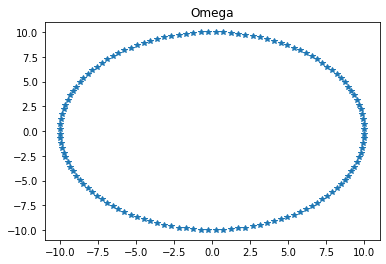

In [3]:
def get_geo(mat, dtype=xp.float64):
    boundary_points = xp.array(mat['boundary_points'], dtype=dtype)  # [2 x n_points]
    boundary_normals = xp.array(mat['boundary_normals'], dtype=dtype)  # [2 x n_points]
    dl = xp.array(mat['dl'], dtype=dtype)  # [1 x n_points]
    curvature = xp.array(mat['curvature'], dtype=dtype)  # [1 x n_points]
    region_area = xp.array(mat['omega_area'], dtype=dtype)  # [1 x 1]
    return boundary_points, boundary_normals, dl, curvature, region_area

# load saved model
mat = io.loadmat('geo.mat')
boundary_points, boundary_normals, dl, curvature, region_area = get_geo(mat)

if xp is np:
    plt.plot(boundary_points[0,:], boundary_points[1,:], '*')
else:
    # convert cupy ndarray to numpy array
    plt.plot(xp.asnumpy(boundary_points[0,:]), xp.asnumpy(boundary_points[1,:]), '*')
plt.title('Omega')

# Single layer potential representation
We choose to represent the solution $\omega(x,t)$ as a single layer potential with a density function $\mu$ defined on $\partial \Omega$:
$$\omega(\mathbf{x},t) = S[\mu](\mathbf{x}, t) \equiv \mathcal{D}_0 \int_{0}^{t} \int_{\partial \Omega} G(\mathbf{x}-\mathbf{y},t-\tau) \mu(\mathbf{y},\tau) ds_{\mathbf{y}} d\tau$$
where $G(\mathbf{x},t)$ is the fundamental solution of the 2D diffusion equation in a box $[-L/2, L/2] \times [-L/2, L/2]$ with periodic boundary conditions.
The density $\mu$ is chosen to be a causal function and is determined by imposing the Neumann boundary conditions:
$$ \lim_{\mathbf{x}\rightarrow \mathbf{x}_0\in \partial \Omega} \mathcal{D}_0 \nabla S[\mu](\mathbf{x},t) \cdot \mathbf{n} = \mathcal{N}(\mathbf{x}_0,t)
\equiv  2\pi \jmath \rho \mathcal{D}_0 \mathbf{q}\cdot \mathbf{n}
e^{-4\pi^2 \mathcal{D}_0  \|\mathbf{q}\|^2 t}e^{-2\pi \jmath \mathbf{q}\cdot\mathbf{x}_0}, \mathbf{x}_0 \in \partial \Omega.$$

Due the singularity of the fundamental solution $G$ when $\tau \rightarrow t$, we split the single layer potential into a short time part and a long time part at time $t-\eta$, with $\eta$ a small quantity to be determined:
$$S[\mu](\mathbf{x},t) = \color{red}{\int_{t-\eta}^{t} ...} + \int_0^{t-\eta} ... = \color{red}{S_{short}[\mu](\mathbf{x},t)} + S_{long}[\mu](\mathbf{x},t)$$

According to [[Greengard1989]](https://www.math.nyu.edu/faculty/greengar/preprint_GS1.pdf), the asymptotic expressions in two dimensions for the short time part is:
\begin{equation}
	S_{short}[\mu](\mathbf{x}_0, t) = \sqrt{\frac{\mathcal{D}_0 \eta}{\pi}} \mu(\mathbf{x}_0, t) + O(\eta^{3/2})
\end{equation}

The smooth part of the single layer potential has a Fourier representation:
\begin{equation}
S_{long}[\mu](\mathbf{x}_0, t) = \mathcal{D}_0 \sum_{\nu = -\nu_{max}}^{\nu_{max}} \hat{f}(\nu, t) e^{2\pi \jmath \nu \cdot \mathbf{x}_0} \Delta \nu^2
\end{equation}
with
$$\hat{f}(\nu, t) =  \int_{\partial \Omega}\int_{0}^{t-\eta} e^{-4\pi^2 \mathcal{D}_0 \|\nu\|^2(t-\tau)}  e^{-2\pi \jmath \nu \cdot \mathbf{y}} \mu(\mathbf{y}, \tau)d\tau ds_{\mathbf{y}}, \quad \nu \in [-\nu_{max}, \nu_{max}]^2.$$

For more details, please read our paper.


In [13]:
def get_time(sdelta, bdelta, dt, dtype=xp.float64):
    return xp.linspace(0, bdelta-sdelta, round((bdelta-sdelta)/dt) +
                       1, dtype=dtype).reshape((1, -1))

def get_freq(freq_max, q_max, freq_resolution, dtype=xp.float64):
    n_temp = int(2*xp.ceil((freq_max+q_max)/freq_resolution) + 1)
    temp = xp.linspace(-freq_max-q_max, freq_max+q_max,
                       n_temp, dtype=dtype)
    freq_y, freq_x = xp.meshgrid(-temp, temp)
    # freq: [2 x n_freqs]
    freq = xp.concatenate(
        (freq_x.reshape((1, -1)), freq_y.reshape((1, -1))), axis=0)
    freq_square = (freq**2).sum(axis=0).reshape(1, -1)  # [1 x n_freqs]
    return freq, freq_square

# simulation setting
dt = 5  # (us)
n_eta = 2
eta = n_eta*dt  # (us)
freq_resolution = 0.01  # (um^-1)
freq_max = 1  # (um^-1)

time_val = get_time(sdelta, bdelta, dt)
freq, freq_square = get_freq(freq_max, 0, freq_resolution)

# some constants
n_points, n_time = boundary_points.shape[1], time_val.shape[1]
n_freqs, n_q = freq.shape[1], q.shape[1]
print('number of points/samples on the boundary: {}'.format(n_points))
print('number of time steps: {}'.format(n_time))
print('number of Fourier modes: {}'.format(n_freqs))
print('number of q-vectors: {}'.format(n_q))
# init
mu = xp.empty((n_q, n_points, n_time), dtype=ctype)
S_short = xp.empty((n_q, n_points, n_time), dtype=ctype)
K_long = xp.zeros((n_q, n_points, n_time), dtype=ctype)
fhat = xp.zeros((n_q, n_freqs, n_time), dtype=ctype)
omega_bar = xp.zeros((n_q, n_time), dtype=ctype)

number of points/samples on the boundary: 128
number of time steps: 501
number of Fourier modes: 40401
number of q-vectors: 10


The complex-valued Neumann data is defined as 
$$\mathcal{N}(\mathbf{x}_0, t) = 2\pi \jmath\mathbf{q} \cdot \mathbf{n}(\mathbf{x}_0)
e^{-4 \pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2 t}e^{-2\pi \jmath\mathbf{q}\cdot\mathbf{x}_0},
\quad \mathbf{x}_0 \in \partial \Omega , \quad t \in [0,\Delta-\delta].$$

In [7]:
def neumann(points, normals, q, q_square, t_val, D0=1e-3):
    n_q = q_square.shape[1]
    xq = 2*xp.pi*1j*((normals.T @ q) *
                     xp.exp(-2*xp.pi*1j*points.T @ q)).T.reshape(n_q, -1, 1)
    qt = xp.exp(-4*xp.pi**2*D0*q_square.T @ t_val).reshape(n_q, 1, -1)
    return xq @ qt

# neumann data [n_q x n_points x n_time]
neu_data = neumann(boundary_points, boundary_normals, q, q_square, time_val, D0=D0)

## $0<= t <= \eta$
When $0<= t <= \eta$, the expression of the density funtion $\mu$ is
$$\mu(\mathbf{x}_0, t) = \frac{2\mathcal{N}(\mathbf{x}_0, t)}{1 - \sqrt{\frac{\mathcal{D}_0 t}{\pi}}\kappa(\mathbf{x}_0)},
	\quad \mathbf{x}_0 \in \partial \Omega , \quad t \in [0,\eta]$$
and
\begin{equation}
	S_{short}[\mu](\mathbf{x}_0, t) = \sqrt{\frac{\mathcal{D}_0 t}{\pi}} \mu(\mathbf{x}_0, t)
\end{equation}

In [8]:
# compute density mu for [0, eta=n_eta*dt] (us)
mu[:, :, :n_eta+1] = 2 * neu_data[:, :, :n_eta+1] / (1 - curvature.T @ xp.sqrt(D0*time_val[:, :n_eta+1]/xp.pi))
S_short[:, :, :n_eta + 1] = xp.sqrt(D0*time_val[:, :n_eta+1]/xp.pi) * mu[:, :, :n_eta+1]

## $\eta< t <= 2\eta$
1. We compute the Fourier coefficients $\hat{f}$ at time $t \in (\eta,\ 2\eta]$:
$$\hat{f}(\nu, t) =  e^{-4\pi^2 \mathcal{D}_0 \|\nu\|^2 \Delta t}\hat{f}(\nu, t - \Delta t) + \underbrace{\int_{\partial \Omega}\int_{t-\eta-\Delta t}^{t-\eta} e^{-4\pi^2 \mathcal{D}_0 \|\nu\|^2(t-\tau)}  e^{-2\pi \jmath \nu \cdot \mathbf{y}} \mu(\mathbf{y}, \tau)d\tau ds_{\mathbf{y}}}_{\hat{f}_{temp1}(\nu, t)}$$
with
$$\hat{f}_{temp1}(\nu, t) = \int_{\partial \Omega} 4\pi \jmath \mathbf{q}\cdot \mathbf{n} e^{-2\pi \jmath (\mathbf{q}+\nu)\cdot \mathbf{y}} \underbrace{\int_{t-\eta-\Delta t}^{t-\eta} \dfrac{e^{-4\pi^2 \mathcal{D}_0 \left[\|\nu\|^2(t-\tau)+\|\mathbf{q}\|^2 \tau\right]}}{1-\sqrt{\frac{\mathcal{D}_0 \tau}{\pi}}\kappa(\mathbf{y})} d\tau}_{p} ds_{\mathbf{y}}$$
and
\begin{equation}
	p =\begin{cases} -\dfrac{2\pi e^{-4\pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2 t}}{\mathcal{D}_0 \kappa^2(\mathbf{y})} \Big[\kappa(\mathbf{y})\sqrt{\frac{\mathcal{D}_0}{\pi}}\left(\sqrt{t-\eta}-\sqrt{t-\eta-\Delta t}\right)   + \ln\left(\dfrac{1-\kappa(\mathbf{y})\sqrt{\frac{\mathcal{D}_0}{\pi}(t-\eta)}}{1 - \kappa(\mathbf{y})\sqrt{\frac{\mathcal{D}_0}{\pi}(t-\eta-\Delta t)}}\right) \Big] & \|\nu\| = \|\mathbf{q}\|     \\
		 e^{-4 \pi^2 \mathcal{D}_0 \left[\|\mathbf{q}\|^2(t-\eta) +\|\nu\|^2 \eta\right]} \Big[\dfrac{1+e^{4 \pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2-\|\nu\|^2)\Delta t}(4 \pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2-\|\nu\|^2)\Delta t- 1)}{\Delta t(4 \pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2-\|\nu\|^2))^2 \left(1 - \kappa(\mathbf{y})\sqrt{\frac{\mathcal{D}_0}{\pi}(t-\eta-\Delta t)}\right)} + \dfrac{e^{4 \pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2-\|\nu\|^2)\Delta t} - 4 \pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2-\|\nu\|^2)\Delta t- 1}{\Delta t(4 \pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2-\|\nu\|^2))^2 \left(1 - \kappa(\mathbf{y})\sqrt{\frac{\mathcal{D}_0}{\pi}(t-\eta)}\right)}\Big] & \|\nu\| \neq \|\mathbf{q}\|
	\end{cases}
\end{equation}

2. We compute the long time part $K_{long}[\mu]$ at time $t$ by applying the inverse discrete Fourier transform:
$$K_{long}[\mu](\mathbf{x}_0, t) = \mathcal{D}_0 \sum_{\nu=-\nu_{max}}^{\nu_{max}} 2\pi \jmath\nu \cdot \mathbf{n}\hat{f}(\nu, t) e^{2\pi \jmath \nu \cdot \mathbf{x}_0} \Delta\nu^2, 	\quad \mathbf{x}_0 \in \partial \Omega.$$


In [9]:
# compute fhat and K_long for [(n_eta+1)*dt, 2*eta=2*n_eta*dt] (us)
def func_p(t, eta, dt, p_weights, freq_square, q_square, zero_mask, curvature, D0):
    # intg: [n_q x n_freqs x n_points]
    D0_curva_coeff = xp.sqrt(D0/xp.pi)*curvature
    denom1 = 1/(1-D0_curva_coeff*xp.sqrt(t-eta-dt))
    denom2 = 1/(1-D0_curva_coeff*xp.sqrt(t-eta))
    denom = xp.concatenate([denom1, denom2], axis=0)  # [2 x n_points]
    # [n_q x n_freqs x n_points]
    intg = (xp.exp(-4*(xp.pi**2)*D0*(q_square.T * (t-eta) +
                                     freq_square*eta)).reshape(q_square.shape[1], -1, 1) *
            p_weights) @ denom
    # when a == 0
    for iq in range(zero_mask.shape[0]):
        mask_temp = zero_mask[iq, :]
        if mask_temp.any():
            zero_inds = mask_temp.nonzero()
            for ind in zero_inds:
                intg[iq, ind, :] = \
                    -(2*xp.pi/D0)*xp.exp(-4*(xp.pi**2)*D0*q_square[0, iq]*t) * \
                    (curvature*xp.sqrt(D0/xp.pi)*(xp.sqrt(t-eta)-xp.sqrt(t-eta-dt)) +
                     xp.log((1-curvature*xp.sqrt(D0*(t-eta)/xp.pi)) /
                            (1-curvature*xp.sqrt(D0*(t-eta-dt)/xp.pi)))) / \
                    curvature**2
    return intg

# reuseable intermediate results
## [n_q x n_freqs]
freq_zero_mask = (xp.abs(q_square.T-freq_square) <= 1e-20)
## [n_freqs x n_points]
fourier_bases = xp.exp(-2*xp.pi*1j*freq.T @ boundary_points)
## [1 x n_freqs]
exp_dt = xp.exp(-4*(xp.pi**2)*D0*dt*freq_square)
## [n_q x n_freqs x n_points]
exponential_term = xp.exp(-2*xp.pi*1j*(freq.T.reshape(1, -1, 2) + q.T.reshape(-1, 1, 2)) @ boundary_points)
## [n_q x n_points]
normal_derivative_coef = 4*xp.pi*1j*q.T @ boundary_normals
## [n_q x n_freqs x n_points]
coef_temp1 = normal_derivative_coef.reshape(n_q, 1, n_points)*exponential_term
## [n_q x n_freqs]
a = 4*(xp.pi**2)*D0*(q_square.T-freq_square)
## [1 x n_points]
Kshort_appro = 1-xp.sqrt(D0*eta/xp.pi)*curvature
## [n_points x n_freqs]
Klong_fourier_coef = ((2*xp.pi*1j*boundary_normals.T @ freq) * fourier_bases.T.conj())*(D0*freq_resolution**2)
## [n_q x n_freqs x 2]
p_weights = xp.empty((n_q, n_freqs, 2), dtype=rtype)
p_weights[:, :, 0] = (1+(a*dt-1)*xp.exp(a*dt))/((a**2)*dt)
p_weights[:, :, 1] = (xp.exp(a*dt)-a*dt-1)/((a**2)*dt)

# compute fhat and K_long for [(n_eta+1)*dt, 2*eta=2*n_eta*dt] (us)
T2 = np.array(range(n_eta+1, 2*n_eta+1))
for it in T2:
    # [n_q x n_freqs x n_points]
    fhat_integrand = coef_temp1 * func_p(it*dt, eta, dt, p_weights, freq_square, q_square, freq_zero_mask, curvature, D0)
    # [n_q x n_freqs]
    fhat_temp1 = xp.squeeze(fhat_integrand @ dl.T)
    # [n_q x n_freqs x n_time]
    fhat[:, :, it] = fhat_temp1 + fhat[:, :, it-1] * exp_dt

K_long[:, :, T2] = Klong_fourier_coef @ fhat[:, :, T2]

## $2\eta< t <= \Delta-\delta$
1. We compute the Fourier coefficients $\hat{f}$ at time $t \in (2\eta, \Delta-\delta]$:
$$\hat{f}(\nu, t) =  e^{-4\pi^2 \mathcal{D}_0 \|\nu\|^2 \Delta t}\hat{f}(\nu, t - \Delta t) + \underbrace{\int_{\partial \Omega}\int_{t-\eta-\Delta t}^{t-\eta} e^{-4\pi^2 \mathcal{D}_0 \|\nu\|^2(t-\tau)}  e^{-2\pi \jmath \nu \cdot \mathbf{y}} \mu(\mathbf{y}, \tau)d\tau ds_{\mathbf{y}}}_{\hat{f}_{temp2}(\nu, t)}$$
where
\begin{align}
	\hat{f}_{temp2}(\nu, t)  = & \int_{\partial \Omega} 2\left(1-\sqrt{\frac{\mathcal{D}_0 \eta}{\pi}}\kappa(\mathbf{y})\right)^{-1} e^{-2\pi \jmath \nu \cdot \mathbf{y}}\times           \\ &\bigl( 2\pi \jmath \mathbf{q}\cdot \mathbf{n} e^{-2\pi \jmath \mathbf{q}\cdot \mathbf{y}}\underbrace{\int_{t-\eta-\Delta t}^{t-\eta} e^{-4\pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2 \tau+\|\nu\|^2(t-\tau))} d\tau}_{h1}- \underbrace{\int_{t-\eta-\Delta t}^{t-\eta} K_{long}[\mu](\mathbf{y}, \tau)e^{-4\pi^2 \mathcal{D}_0 \|\nu\|^2(t-\tau)}d\tau}_{h2} \bigr) ds_{\mathbf{y}}.
\end{align}
with
\begin{equation}
	h1 =\begin{cases} \Delta t \cdot e^{-4 \pi^2 \mathcal{D}_0 \|\nu\|^2t}                                                                                                                                                                                            & \|\mathbf{q}\| = \|\nu\|    \\
		\dfrac{e^{-4 \pi^2 \mathcal{D}_0 \left[\|\mathbf{q}\|^2 (t-\eta-\Delta t)+\|\nu\|^2 (\eta+\Delta t)\right]}-e^{-4 \pi^2 \mathcal{D}_0 \left[\|\mathbf{q}\|^2 (t-\eta)+\|\nu\|^2 \eta\right]}}{4 \pi^2 \mathcal{D}_0 (\|\mathbf{q}\|^2 - \|\nu\|^2)} & \|\mathbf{q}\| \neq \|\nu\|
	\end{cases}
\end{equation}
and
\begin{equation}
	h2 =\begin{cases} \frac{\Delta t}{2} \left[K_{long}[\mu](\mathbf{y},t-\eta)+K_{long}[\mu](\mathbf{y}, t-\eta-\Delta t)\right]    &\|\nu\| = 0     \\
		e^{-4 \pi^2 \mathcal{D}_0 \|\nu\|^2 \eta}\cdot  \Big[  \frac{1-e^{-4 \pi^2 \mathcal{D}_0 \|\nu\|^2\Delta t}(4 \pi^2 \mathcal{D}_0 \|\nu\|^2\Delta t+1)}{(4 \pi^2 \mathcal{D}_0 \|\nu\|^2)^2\Delta t}K_{long}[\mu](\mathbf{y}, t-\eta-\Delta t) + \frac{e^{-4 \pi^2 \mathcal{D}_0 \|\nu\|^2\Delta t}+ 4 \pi^2 \mathcal{D}_0 \|\nu\|^2\Delta t-1}{(4 \pi^2 \mathcal{D}_0 \|\nu\|^2)^2\Delta t}K_{long}[\mu](\mathbf{y}, t-\eta)\Big] &\|\nu\| \neq 0
	\end{cases}
\end{equation}

2. We compute the long time part $K_{long}[\mu]$ at time $t$ by applying the inverse discrete Fourier transform:
$$K_{long}[\mu](\mathbf{x}_0, t) = \mathcal{D}_0 \sum_{\nu=-\nu_{max}}^{\nu_{max}} 2\pi \jmath\nu \cdot \mathbf{n}\hat{f}(\nu, t) e^{2\pi \jmath \nu \cdot \mathbf{x}_0} \Delta\nu^2, 	\quad \mathbf{x}_0 \in \partial \Omega.$$

In [10]:
# compute fhat and K_long for [(2*n_eta+1)*dt, bdelta-sdelta] (us)
def func_h1(t, eta, dt, freq_square, q_square, zero_mask, D0):
    # output: [n_q x n_freqs x 1]
    # [n_q x n_freqs]
    h1 = (xp.exp(-4*(xp.pi**2)*D0*(q_square.T*(t-eta-dt) + freq_square*(eta+dt))) -
          xp.exp(-4*(xp.pi**2)*D0*(q_square.T*(t-eta) + freq_square*eta))) / \
        (4*(xp.pi**2)*D0*(q_square.T-freq_square))
    for iq in range(zero_mask.shape[0]):
        mask_temp = zero_mask[iq, :]
        if mask_temp.any():
            zero_inds = mask_temp.nonzero()
            for ind in zero_inds:
                h1[iq, ind] = dt * \
                    xp.exp(-4*(xp.pi**2)*D0*q_square[0, iq]*t)
    return h1.reshape(q_square.shape[1], -1, 1)


def func_h2(exp_eta, h2_weights, klong):
    # exp_eta: [1 x n_freqs], h2_weights: [n_freqs x 2], klong: [n_q, n_points, 2]
    # output: [n_q x n_freqs x n_points]
    return exp_eta.reshape(1, -1, 1)*(h2_weights @ klong.transpose(0, 2, 1))

# reuseable intermediate results
## [1 x n_freqs]
exp_eta = xp.exp(-4*(xp.pi**2)*D0*eta*freq_square)
## [n_q x 1 x n_points]
fhat_h1_coef = (normal_derivative_coef/Kshort_appro).reshape(n_q, 1, n_points)
## [n_freqs x n_points]
fhat_h2_coef = (2*fourier_bases/Kshort_appro).reshape(1, n_freqs, n_points)

## [n_freqs]
h2_a = 4*(xp.pi**2)*D0*freq_square.reshape(-1)
## [n_freqs x 2]
h2_weights = xp.zeros((n_freqs, 2), dtype=rtype)
h2_weights[:, 0] = (1 - xp.exp(-h2_a*dt)*(h2_a*dt + 1))/((h2_a**2)*dt)
h2_weights[:, 1] = (xp.exp(-h2_a*dt) + h2_a*dt - 1)/((h2_a**2)*dt)
### when h2_a == 0
h2_weights[xp.abs(h2_a) <= 1e-20, :] = dt/2

# compute fhat and K_long for [(2*n_eta+1)*dt, bdelta-sdelta] (us)
T3 = np.array(range(2*n_eta+1, n_time))
# timing the most expansive part
s = time.time()
for it in T3:
    # [n_q x n_freq]
    fhat_it = exp_dt*fhat[:, :, it-1] + \
        xp.squeeze(
            ((func_h1(it*dt, eta, dt, freq_square, q_square, freq_zero_mask, D0) @
              fhat_h1_coef) * exponential_term -
             func_h2(exp_eta, h2_weights, K_long[:, :, it-n_eta-1:it-n_eta+1])*fhat_h2_coef) @ dl.T)
    fhat[:, :, it] = fhat_it
    K_long[:, :, it] = fhat_it @ Klong_fourier_coef.T
if xp is not np:
  xp.cuda.stream.get_current_stream().synchronize()
e = time.time()
print(e-s)
print('CPU running time for (10 q-vectors, 40401 Fourier modes): 715.17s')

41.01460528373718
CPU running time for (10 q-vectors, 40401 Fourier modes): 715.17s


## Compute $\mu$, $S_{short}$ and $S_{long}$ for $t \in (\eta, \Delta-\delta]$ 
1. $$\mu(\mathbf{x}_0, t) = 2\left(1-\sqrt{\frac{\mathcal{D}_0 \eta}{\pi}}\kappa(\mathbf{x}_0)\right)^{-1}\left[\mathcal{N}(\mathbf{x}_0, t) - K_{long}[\mu](\mathbf{x}_0, \tau)\right]$$

2. $$S_{short}[\mu](\mathbf{x}_0, t) = \sqrt{\frac{\mathcal{D}_0 \eta}{\pi}} \mu(\mathbf{x}_0, t)$$

3. $$S_{long}[\mu](\mathbf{x}_0, t) = \mathcal{D}_0 \sum_{\nu = -\nu_{max}}^{\nu_{max}} \hat{f}(\nu, t) e^{2\pi \jmath \nu \cdot \mathbf{x}_0} \Delta \nu^2$$

4. $$\omega(\mathbf{x}_0, t) = S[\mu](\mathbf{x}_0, t) = S_{short}[\mu](\mathbf{x}_0, t) + S_{long}[\mu](\mathbf{x}_0, t)$$

In [11]:
mu[:, :, n_eta+1:] = 2*(neu_data[:, :, n_eta+1:] - K_long[:, :, n_eta+1:])/Kshort_appro.reshape(1, n_points, 1)
S_short[:, :, n_eta+1:] = xp.sqrt(D0*eta/xp.pi)*mu[:, :, n_eta+1:]
S_long = (fourier_bases.T.conj() @ fhat)*(D0*freq_resolution**2)
omega = S_long + S_short

# Compute the dMRI sigal $\mathcal{S}$
The diffusion MRI signal $\mathcal{S}$ can be formulated in terms of $\omega$:
$$
\mathcal{S} = |\Omega|\rho e^{-4\pi^2 \mathcal{D}_0  \|\mathbf{q}\|^2 (\Delta - \delta)} + \overline{\omega}(\mathbf{q}, \Delta-\delta),
$$
with
\begin{equation}
	\begin{split}
		\overline{\omega}(\mathbf{q}, t) =\ &e^{-4\pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2 \Delta t}\overline{\omega}(\mathbf{q}, t-\Delta t)\\ &- \mathcal{D}_0  \underbrace{\int_{\partial \Omega} 2\pi \jmath \mathbf{q} \cdot \mathbf{n} e^{2\pi \jmath \mathbf{q} \cdot \mathbf{y}} \overbrace{\int_{t-\Delta t}^{t} e^{-4\pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2 (t-\tau)} \omega(\mathbf{y}, \tau)  d\tau}^{u} ds_{\mathbf{y}}}_{\overline{\omega}_{temp}(\mathbf{q}, t)}.
	\end{split}
\end{equation}
and
\begin{equation}
	u =\begin{cases} \frac{\Delta t}{2} \left[\omega(\mathbf{y}, t-\Delta t)+\omega(\mathbf{y}, t)\right] & \|\mathbf{q}\| = 0      \\
		\frac{1-e^{-4 \pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2\Delta t}(4 \pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2\Delta t+1)}{(4 \pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2)^2\Delta t}\omega(\mathbf{y}, t-\Delta t)+\frac{e^{-4 \pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2\Delta t}+ 4 \pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2\Delta t-1}{(4 \pi^2 \mathcal{D}_0 \|\mathbf{q}\|^2)^2\Delta t}\omega(\mathbf{y}, t) & \|\mathbf{q}\| \neq 0
	\end{cases}
\end{equation}

[1.         0.98070059 0.92506977 0.83949431 0.73318869 0.61661236
 0.49985065 0.39100575 0.29559557 0.21656677]


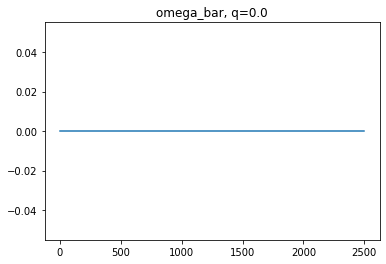

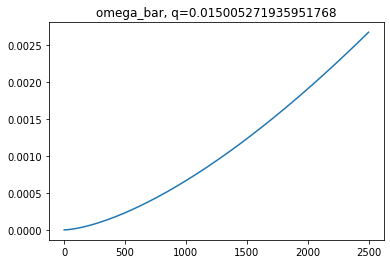

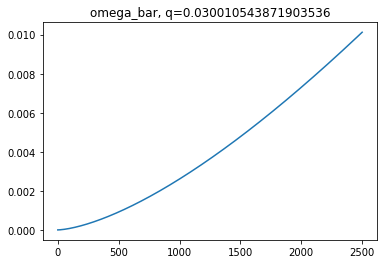

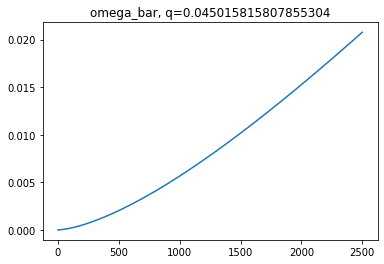

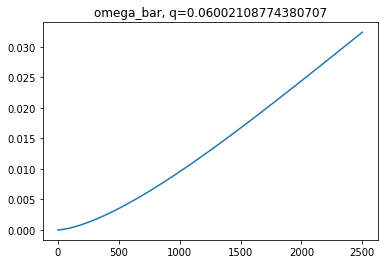

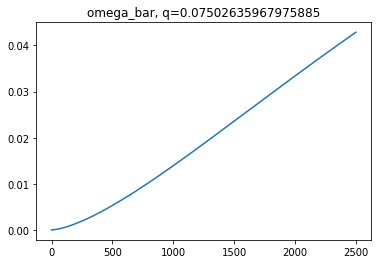

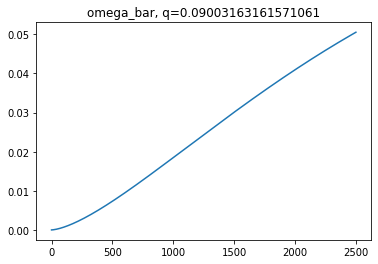

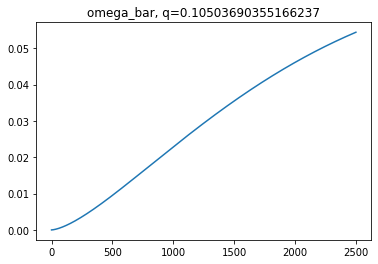

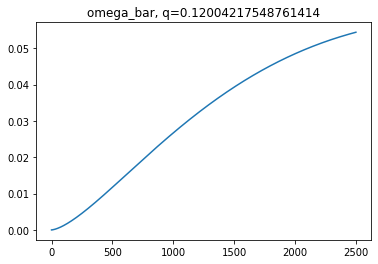

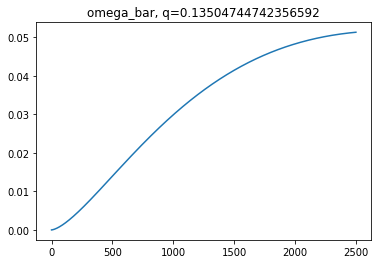

In [12]:
# reuseable intermediate results
u = xp.zeros((n_q, n_points, n_time), dtype=ctype)
omega_bar_a = 4*(xp.pi**2)*D0*q_square.reshape((n_q, 1, 1))
weight1 = (1 - xp.exp(-omega_bar_a*dt) * (omega_bar_a*dt + 1))/(omega_bar_a**2*dt)
weight2 = (xp.exp(-omega_bar_a*dt) + omega_bar_a*dt - 1)/(omega_bar_a**2*dt)
## [n_q x n_points x n_time] matrix
u[:, :, 1:] = weight1*omega[:, :, 0:-1] + weight2*omega[:, :, 1:]
for iq in range(n_q):
    if np.abs(q_square[0, iq]) < 1e-20:
        u[iq, :, 1:] = (omega[iq, :, 0:-1] + omega[iq, :, 1:])*dt/2

# compute omega_bar for [0, bdelta-sdelta] (us)
omega_bar_temp = xp.squeeze(dl @ (u*(2*xp.pi*1j*(q.T @ boundary_normals) *
                                     xp.exp(2*xp.pi*1j*q.T@boundary_points)).reshape(n_q, n_points, 1)))
for it in range(1, n_time):
    omega_bar[:, it] = xp.exp(-4*(xp.pi**2)*D0*q_square.reshape(-1)*dt) * \
        omega_bar[:, it-1] - D0*omega_bar_temp[:, it]
# [n_q x n_time]
omega_bar = omega_bar/region_area

for iq in range(n_q):
  plt.figure()
  if xp is np:
      plt.plot(time_val.flatten(), xp.real(omega_bar[iq,:]).flatten())
      plt.title('omega_bar, q={}'.format(xp.sqrt(q_square[0, iq])))
  else:
      # convert cupy ndarray to numpy array
      plt.plot(xp.asnumpy(time_val).flatten(), xp.asnumpy(xp.real(omega_bar[iq,:])).flatten())
      plt.title('omega_bar, q={}'.format(xp.asnumpy(xp.sqrt(q_square[0, iq]))))
  
# dMRI signal
normalized_signal = xp.real(xp.exp(-4*xp.pi**2*D0*q_square[0,:]*(bdelta-sdelta)) + omega_bar[:, -1]).reshape(-1)
print(normalized_signal)